In [27]:
from pathlib import Path
import csv
import math
import numpy as np
import random
from heapq import nsmallest
%matplotlib inline
import matplotlib.pyplot as plt
from copy import deepcopy
from joblib import Parallel, delayed
from matplotlib.patches import Polygon
from matplotlib.animation import FuncAnimation, PillowWriter
import time
import scipy
import itertools
import pandas as pd
from smart_mobility_utilities.common import probability
import svgutils.transform as sg
from IPython.display import display, Image, SVG

# K-Means Clustering Location Problem Solver

In [28]:
df = pd.read_csv("./DatasetGen/synthetic_dataset.csv")
df.rename(columns = {'Number Deliveries':'demand'}, inplace = True)
print(df.columns.tolist())
demand = df["demand"]
df = df[["X", "Y"]]
data = df.to_numpy()

['Node ID', 'Node OSMID', 'X', 'Y', 'Node Weight', 'demand']


In [29]:
total_demand = demand.sum()
capacity = 1200
min_K = total_demand // capacity
min_K

833

In [30]:
def cost(data, R, Mu):
    N, D = data.shape
    K = Mu.shape[1]
    J = 0
    for k in range(K):
      J += np.dot(np.linalg.norm(data - np.array([Mu[:, k], ] * N), axis=1)**2, R[:, k])
    return J

In [31]:
def km_assignment_step(data, Mu):
    """ Compute K-Means assignment step
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        R_new: a NxK matrix of responsibilities
    """
    
    N, D = data.shape  # TODO: Number of datapoints and dimension of datapoint
    K =  Mu.shape[1] # number of clusters
    r = np.zeros((N, K))  # TODO
    # TODO assign all r[:, k]
    for k in range(K):
      r[:, k] = np.linalg.norm(data - np.array([Mu[:, k], ]*N), axis=1)**2

    arg_min = np.argmin(r, axis=1) # TODO: argmax/argmin along dimension 1
    R_new = np.zeros((N, K)) # TODO: Set to zeros/ones with shape (N, K)
    R_new[np.arange(N), arg_min] = 1 # TODO Assign to 1
    return R_new

In [32]:
# TODO: K-means Refitting Step
def km_refitting_step(data, R, Mu):
    """ Compute K-Means refitting step.
    
    Args:
        data: a NxD matrix for the data points
        R: a NxK matrix of responsibilities
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        Mu_new: a DxK matrix for the new cluster means locations
    """
    N, D =  data.shape
    K = Mu.shape[1]
    Mu_new =  (np.matmul(data.T, R))/np.sum(R, axis=0) # TODO
    return Mu_new

In [33]:
N, D = data.shape 
K = min_K
max_iter = 100
d = demand.to_numpy()

def capacitated_k_means(data, K, N, D, max_iter, demand):
  R = np.zeros((N, K))
  idx = np.random.choice(data.shape[0], size=K, replace=False)
  Mu = np.zeros([D, K])
  for i in range(K):
    Mu[:, i] = data[idx[i]]

  for it in range(max_iter):
    R = km_assignment_step(data, Mu) 
    Mu = km_refitting_step(data, R, Mu) 

  dpc = d.dot(R)
  utilization = np.where(dpc>capacity, dpc-capacity, dpc-capacity)
  if (np.sum(utilization) > 0):
    return capacitated_k_means(data, K + 1, N, D, max_iter, demand)
  return Mu, R

In [34]:
Mu, R = capacitated_k_means(data, K, N, D, max_iter, d)

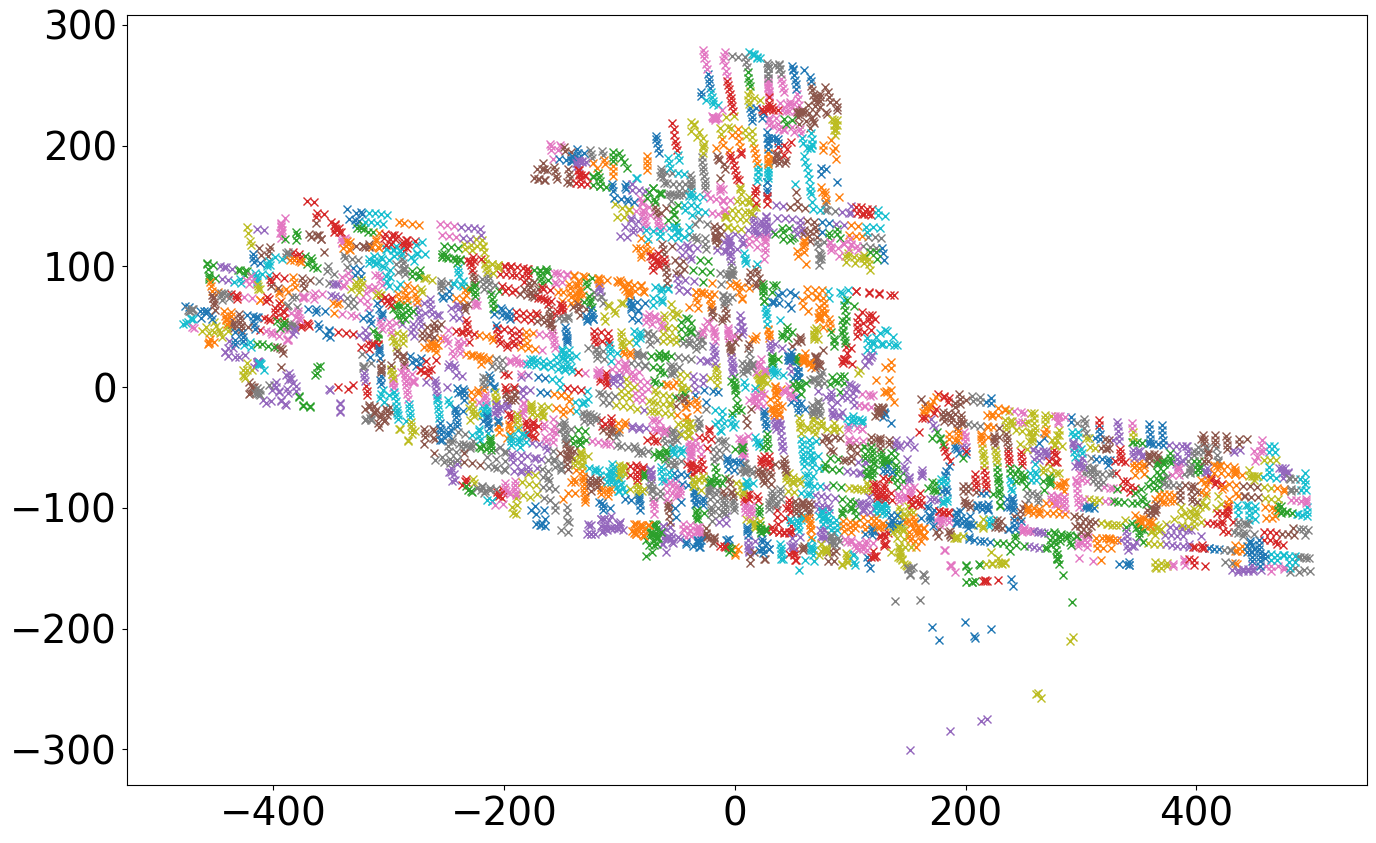

In [35]:
for i in range(R.shape[1]):
  cluster = np.where(R[:, i]) 
  plt.plot(data[cluster][:, 0], data[cluster][:, 1], "x")

In [36]:
print(R.shape)
dpc = d.dot(R)
utilization = np.where(dpc>capacity, dpc-capacity, dpc-capacity)
print(np.sum(utilization))

(5797, 834)
-800.0


# Simulated Annealing Location Problem Solver

In [37]:
class SASolveFacilityProblem:
    def __init__(
            self, 
            nodes_info,
            total_deliveries, 
            facility_capacity, 
            facility_cost, 
            facility_increase_prob, 
            facility_decrease_prob, 
            num_neighbours,
            num_iterations,
            k,
            lam
    ):

        self.nodes_info = nodes_info
        self.total_deliveries = total_deliveries
        self.facility_capacity = facility_capacity
        self.facility_cost = facility_cost
        self.facility_increase_prob = facility_increase_prob
        self.facility_decrease_prob = facility_decrease_prob
        self.num_neighbours = num_neighbours
        self.min_facilities = math.ceil(self.total_deliveries / float(facility_capacity)) # there have to be at least CAP / NUM_DELIVERIES facilities to serve demand
        self.cost_matrix = None
        self.ordered_matrix = None
        self.distance_from_downtown_matrix = None

        self.estimated_dtwn_x = -3.7178296565262885e-14
        self.estimated_dtwn_y = -2.6310964646970894e-13
        self.max_distance_to_dtwn = 0
        self.min_distance_to_dtwn = 0
        self.min_bid_rent_multiplier = 0.3

        self.overdemand_penalty = 100

        self.min_x = 0
        self.max_x = 0
        self.min_y = 0
        self.max_y = 0

        self.num_iterations = num_iterations
        self.k = k
        self.lam = lam
        self.limit = num_iterations

        self.states = []
        self.states_full = []
        self.solution = None
        self.solution_cost = None

        random.seed(100) # to keep consistency through different runs

    def calculate_closest_nodes(self, solution):
        facilities_closest_nodes = [[] for i in range(len(solution))]
        facilities_available_space = [self.facility_capacity for i in range(len(solution))]
        visited_nodes_set = set()
        for i, facility in enumerate(solution):
            closest_node_indexes = self.ordered_matrix[facility[2]]
            for node_id in closest_node_indexes:
                node_cost = self.nodes_info[node_id][2]
                if node_id not in visited_nodes_set and facilities_available_space[i] - node_cost >= 0:
                    facilities_closest_nodes[i].append([node_id, self.cost_matrix[facility[2]][node_id]])
                    facilities_available_space[i] -= node_cost
                    visited_nodes_set.add(node_id)
                elif node_id not in visited_nodes_set and facilities_available_space[i] - node_cost < 0:
                    break
        all_nodes_set = set(range(0, len(self.nodes_info)))
        not_visited_nodes_set = list(all_nodes_set.difference(visited_nodes_set))

        for node_id in not_visited_nodes_set:

            node_cost = self.nodes_info[node_id][2]

            most_available_facility = 0
            available_space_at_facility = facilities_available_space[most_available_facility]
            for i, facility in enumerate(solution):
                if available_space_at_facility < facilities_available_space[i]:
                    most_available_facility = i
                    available_space_at_facility = facilities_available_space[i]
            facilities_closest_nodes[most_available_facility].append([node_id, self.cost_matrix[most_available_facility][node_id]])
            facilities_available_space[most_available_facility] -= node_cost

        return facilities_closest_nodes

    def calculate_facility_cost(self, facility_closest_nodes):
        total_cost = 0
        total_demand = 0
        for node in facility_closest_nodes:
            total_cost += node[1] * self.nodes_info[node[0]][2]  # add the distance from node to facility and back, which is already squared, times the demand for that node
            total_demand += self.nodes_info[node[0]][2]
        return total_cost if total_demand <= self.facility_capacity else total_cost * self.overdemand_penalty

    def facility_placement_cost(self, facility_id):
        distance_to_downtown = self.distance_from_downtown_matrix[facility_id]
        bid_rent_multiplier = 1 - self.min_bid_rent_multiplier * (distance_to_downtown - self.min_distance_to_dtwn) / (self.max_distance_to_dtwn - self.min_distance_to_dtwn)
        return bid_rent_multiplier

    def cost_function(self, solution):
        total_cost = 0
        facilities_closest_nodes = self.calculate_closest_nodes(solution)
        for i, closest_nodes in enumerate(facilities_closest_nodes):
            cost = self.calculate_facility_cost(closest_nodes)
            bid_rent_multiplier = self.facility_placement_cost(solution[i][2])
            total_cost += cost * bid_rent_multiplier
        total_cost = total_cost * (len(solution) ** 2) # heavily penalize the number of facilities to minimize them
        return total_cost

    def gen_random_solution(self):
        gen_facilities = []
        copy_nodes_info = deepcopy(self.nodes_info)
        for i in range(0, self.min_facilities):
            random_node_id = random.randint(0, len(copy_nodes_info) - 1)
            selected_node = copy_nodes_info.pop(random_node_id)
            selected_node.append(random_node_id)
            gen_facilities.append(selected_node)
        return gen_facilities

    def exponential_scheduling(k=20, lam=0.005, limit=100):
        function = lambda t: (k * np.exp(-lam*t) if t < limit else 0)
        return function

    def neighbour_function(self, solution):
        mutated_population_element = []
        for facility in solution:
            sorted_closest_nodes = self.ordered_matrix[facility[2]]
            random_index = random.randint(0, self.num_neighbours)
            new_node_index = sorted_closest_nodes[random_index]
            new_x = self.nodes_info[new_node_index][0]
            new_y = self.nodes_info[new_node_index][1]

            mutated_population_element.append([new_x, new_y, new_node_index])
        
        # if we randomly decide to eliminate a facility from the population element
        if len(solution) > self.min_facilities and random.random() > self.facility_decrease_prob:
            # remove the last element from the population element (last facility)
            mutated_population_element.pop(len(mutated_population_element) - 1)
        
        # if we randomly decide to add a facility to the population element
        if random.random() > self.facility_increase_prob:
            random_new_index_node = random.randint(0, len(self.nodes_info) - 1)
            new_facility_node = self.nodes_info[random_new_index_node]
            mutated_population_element.append([new_facility_node[0], new_facility_node[1], random_new_index_node])

        return mutated_population_element

    def initialize(self):
        first_node = True
        for node in self.nodes_info:
            if first_node:
                self.max_x = node[0]
                self.min_x = node[0]
                self.max_y = node[1]
                self.min_y = node[1]
                first_node = False
            else:
                if node[0] > self.max_x:
                    self.max_x = node[0]
                if node[0] < self.min_x:
                    self.min_x = node[0]
                if node[1] > self.max_y:
                    self.max_y = node[1]
                if node[1] < self.min_y:
                    self.min_y = node[1]
        
        self.cost_matrix = np.zeros((len(self.nodes_info), len(self.nodes_info)))
        print("Initializing cost matrix...")
        for i, node_i in enumerate(self.nodes_info):
            for j, node_j in enumerate(self.nodes_info):
                x_dist = node_i[0] - node_j[0]
                y_dist = node_i[1] - node_j[1]
                self.cost_matrix[i, j] = x_dist * x_dist + y_dist * y_dist # distance without sqrt to increase performance (dirty distance)
        print("Initialized cost matrix")
        print("Initializing the ordered index closest nodes matrix...")
        temp_ordered_matrix = []
        for i in range(0, len(self.nodes_info)):
            node_i_ordered_indexes = np.argsort(self.cost_matrix[i])
            temp_ordered_matrix.append(node_i_ordered_indexes.tolist())
        self.ordered_matrix = np.array(temp_ordered_matrix)
        print("Initialized the ordered index closest nodes matrix")

        print("Initializing the distance to downtown matrix...")
        self.distance_from_downtown_matrix = np.zeros(len(self.nodes_info))
        for i, node_i in enumerate(self.nodes_info):
            x_dist = self.estimated_dtwn_x - node_i[0]
            y_dist = self.estimated_dtwn_y - node_i[1]
            self.distance_from_downtown_matrix[i] = x_dist * x_dist + y_dist * y_dist
        self.max_distance_to_dtwn = np.max(self.distance_from_downtown_matrix)
        self.min_distance_to_dtwn = np.min(self.distance_from_downtown_matrix)
        print("Initialized the distance to downtown matrix")

        print("Generating initial solution...")
        self.solution = self.gen_random_solution()
        self.solution_cost = self.cost_function(self.solution)
        print("Initial solution generated! Solution cost is " + str(self.solution_cost))
        

    def solve(self):
        self.states.append(self.solution_cost)
        self.states_full.append(self.solution)
        current = self.solution

        start_time = time.time()
        for iter in range(self.num_iterations):
            print("Iteration ", str(iter))
            T = SASolveFacilityProblem.exponential_scheduling(self.k, self.lam, self.limit)(iter)
            next_choice = self.neighbour_function(current)
            current_cost = self.cost_function(current)
            next_cost = self.cost_function(next_choice)
            delta_e = next_cost - current_cost
            if delta_e < 0 or np.exp(-1 * delta_e / T) > random.uniform(0.0, 1.0):
                current = next_choice
            self.states.append(self.cost_function(current))
            self.states_full.append(current)
        end_time = time.time()

        self.solution = current
        self.solution_cost = self.cost_function(current)
        print("Best Solution:", self.solution)
        print("Best Solution Cost:", self.solution_cost)
        print("Total time to complete: " + str(end_time - start_time) + " seconds")

    def visualize_solution(self):
        large = 32; med = 28; small = 24
        params = {'axes.titlesize': large,
                    'legend.fontsize': large,
                    'figure.figsize': (16, 10),
                    'axes.labelsize': med,
                    'axes.titlesize': med,
                    'xtick.labelsize': med,
                    'ytick.labelsize': med,
                    'figure.titlesize': large}
        plt.rcParams.update(params)

        plt.figure(figsize=(16,8), dpi= 80)
        plt.ylabel("Y Coordinate of Node", fontsize=med)  
        plt.xlabel("X Coordinate of Node", fontsize=med) 
        plt.title("Calculated Delivery Centers Map - w/Clustered Nodes", fontsize=large)
        plt.xlim((self.min_x, self.max_x))
        plt.ylim((self.min_y, self.max_y))

        nodes_per_facility = self.calculate_closest_nodes(self.solution)
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(nodes_per_facility))]
        total_deliveries_served = 0
        for i, facility_close_nodes in enumerate(nodes_per_facility):
            x_coordinates = []
            y_coordinates = []
            total_deliveries_assigned = 0
            for node in facility_close_nodes:
                x_coordinates.append(self.nodes_info[node[0]][0])
                y_coordinates.append(self.nodes_info[node[0]][1])
                total_deliveries_assigned += self.nodes_info[node[0]][2]
                total_deliveries_served += self.nodes_info[node[0]][2]
            print("Facility " + str(i) + " has " + str(total_deliveries_assigned) + " deliveries assigned to it.")
            plt.scatter(x_coordinates, y_coordinates, color=color[i], alpha=0.5, edgecolors='none', s=200)
        print("The total number of deliveries served is " + str(total_deliveries_served))
        x_coordinates = []
        y_coordinates = []
        for facility in self.solution:
            x_coordinates.append(facility[0])
            y_coordinates.append(facility[1])
        plt.scatter(x_coordinates, y_coordinates, color="#FF0000")
        plt.scatter([self.estimated_dtwn_x], [self.estimated_dtwn_y], color="#00FF00")
        plt.savefig("k" + str(self.k) + "_lam" + str(self.lam) + "_" + "sa_solution.svg", format="svg")
        #plt.show(block=False)

        plt.cla()
        large = 32; med = 28; small = 24
        params = {'axes.titlesize': large,
                    'legend.fontsize': large,
                    'figure.figsize': (16, 10),
                    'axes.labelsize': med,
                    'axes.titlesize': med,
                    'xtick.labelsize': med,
                    'ytick.labelsize': med,
                    'figure.titlesize': large}
        plt.rcParams.update(params)

        plt.figure(figsize=(16,8), dpi= 80)
        plt.ylabel("Cost of Best Solution", fontsize=med)  
        plt.xlabel("# Iteration", fontsize=med) 
        plt.title("Cost of Best Solution Through The Iterations", fontsize=large)
        plt.plot(self.states)
        plt.savefig("k" + str(self.k) + "_lam" + str(self.lam) + "_" + "sa_solution_progression.svg", format="svg")

        plt.cla()

        writer = PillowWriter(fps=5)
        large = 32; med = 28; small = 24
        params = {'axes.titlesize': large,
                    'legend.fontsize': large,
                    'figure.figsize': (16, 10),
                    'axes.labelsize': med,
                    'axes.titlesize': med,
                    'xtick.labelsize': med,
                    'ytick.labelsize': med,
                    'figure.titlesize': large}
        plt.rcParams.update(params)

        fig2 = plt.figure(figsize=(16,8), dpi= 80)
        plt.ylabel("Y Coordinate of Node", fontsize=med)  
        plt.xlabel("X Coordinate of Node", fontsize=med) 
        plt.title("Progression of Delivery Center Locations Over Time", fontsize=large)
        plt.xlim((self.min_x, self.max_x))
        plt.ylim((self.min_y, self.max_y))
        animation_points = []
        with writer.saving(fig2, "k" + str(self.k) + "_lam" + str(self.lam) + "_" + "sa_facility_locations_progression.gif", 100):
            for i in range(0, len(self.states_full)):
                x_coordinates = []
                y_coordinates = []
                for facility in self.states_full[i]:
                    x_coordinates.append(facility[0])
                    y_coordinates.append(facility[1])
                writer.grab_frame()
                animation_points.append(plt.scatter(x_coordinates, y_coordinates, color="#FF0000"))
                if len(animation_points) == 2:
                    animation_points[0].remove()
                    animation_points.pop(0)

    def write_costs_overtime_to_csv(self):
        print("Saving solution progression to .csv file...")
        save_path = Path("k" + str(self.k) + "_lam" + str(self.lam) + "_sa_progression.csv")
        with open(save_path, mode='w', encoding='utf-8') as solutionwriter:
            csvsolutionwriter = csv.writer(solutionwriter, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csvsolutionwriter.writerow(["cost"])
            for state in self.states:
                csvsolutionwriter.writerow([state])

    def write_facility_placements_to_csv(self):
        print("Saving final facility placements to .csv file...")
        save_path = Path("k" + str(self.k) + "_lam" + str(self.lam) + "_sa_locations.csv")
        with open(save_path, mode='w', encoding='utf-8') as solutionwriter:
            csvsolutionwriter = csv.writer(solutionwriter, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csvsolutionwriter.writerow(["node_id", "x", "y"])
            for facility in self.solution:
                csvsolutionwriter.writerow([facility[2], facility[0], facility[1]])

    def get_csv_file_name(self):
        return "./k" + str(self.k) + "_lam" + str(self.lam) + "_sa_locations.csv"
    
    def get_solution_image_name(self):
        return "./k" + str(self.k) + "_lam" + str(self.lam) + "_" + "sa_solution.svg"

    def get_progression_graph_name(self):
        return "./k" + str(self.k) + "_lam" + str(self.lam) + "_" + "sa_solution_progression.svg"
    
    def get_animation_name(self):
        return "./k" + str(self.k) + "_lam" + str(self.lam) + "_" + "sa_facility_locations_progression.gif"

In [38]:
# loads the synthetic dataset from a .csv file
# the synthetic dataset must have the following columns:
# Node ID, Node OSMID, X, Y, Node Weight, Number Deliveries
def load_dataset(string_path):
    dataset_path = Path(string_path)
    nodes_info = []
    print("Opening dataset file and loading dataset...")
    with open(dataset_path, mode='r', encoding='utf-8') as datasetreader:
        csvdatasetreader = csv.reader(datasetreader, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        line_number = 0
        for row in csvdatasetreader:
            if line_number == 0:
                print("Reading synthetic dataset file")
                line_number += 1
            else:
                node_id = int(row[0])
                node_osmid = int(float(row[1]))
                node_x = float(row[2])
                node_y = float(row[3])
                node_weight = float(row[4])
                node_deliveries = int(row[5])
                nodes_info.append([node_id, node_osmid, node_x, node_y, node_weight, node_deliveries])
    print("Dataset loaded! Found " + str(len(nodes_info)) + " nodes.")
    return nodes_info

In [39]:
# unwraps or expands the deliveries in each node, converting them to nodes with the same coordinates
# for ease of use in the algorithms
def prepare_dataset(nodes_info):
    prepared_dataset = []
    print("Preparing the dataset for use in the algorithms...")
    total_deliveries = 0
    for node in nodes_info:
        # for every delivery for that node, create a new node with same location
        #for _ in range(0, node[5]):
            # only save node X,Y coordinates, as after expanding the deliveries, this is all that matters
        prepared_dataset.append([node[2], node[3], node[5]])
        total_deliveries += node[5]
    print("Dataset preparation complete! Expanded " + str(len(prepared_dataset)) + " deliveries.")
    return total_deliveries, prepared_dataset

In [40]:
facility_capacity = 1200
facility_cost = 5000
num_iterations = 100
facility_increase_prob = 0.2
facility_decrease_prob = 0.4
num_neighbours_nodes_div = 10
exp_schedule_k = 1
exp_schedule_lam = 0.001

In [41]:
dataset = load_dataset("./DatasetGen/synthetic_dataset.csv")
total_deliveries, prepared_dataset = prepare_dataset(dataset)
k_to_try = [1, 10, 20, 50, 70, 100, 200]
lam_to_try = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
best_solution_cost = float("inf")
best_k = k_to_try[0]
best_lam = lam_to_try[0]
do_ablation = False

Opening dataset file and loading dataset...
Reading synthetic dataset file
Dataset loaded! Found 5797 nodes.
Preparing the dataset for use in the algorithms...
Dataset preparation complete! Expanded 5797 deliveries.


Initializing cost matrix...
Initialized cost matrix
Initializing the ordered index closest nodes matrix...
Initialized the ordered index closest nodes matrix
Initializing the distance to downtown matrix...
Initialized the distance to downtown matrix
Generating initial solution...
Initial solution generated! Solution cost is 1.173990942594572e+18
Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19
Iteration  20
Iteration  21
Iteration  22
Iteration  23
Iteration  24
Iteration  25
Iteration  26
Iteration  27
Iteration  28
Iteration  29
Iteration  30
Iteration  31
Iteration  32
Iteration  33
Iteration  34
Iteration  35
Iteration  36
Iteration  37
Iteration  38
Iteration  39
Iteration  40
Iteration  41
Iteration  42
Iteration  43
Iteration  44
Iteration  45
Iteration  46
Iter

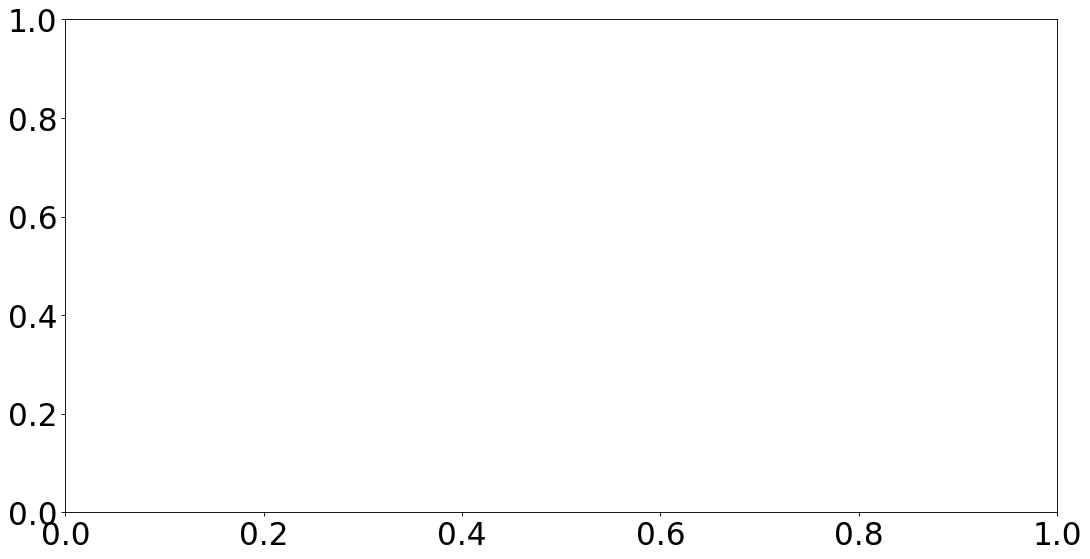

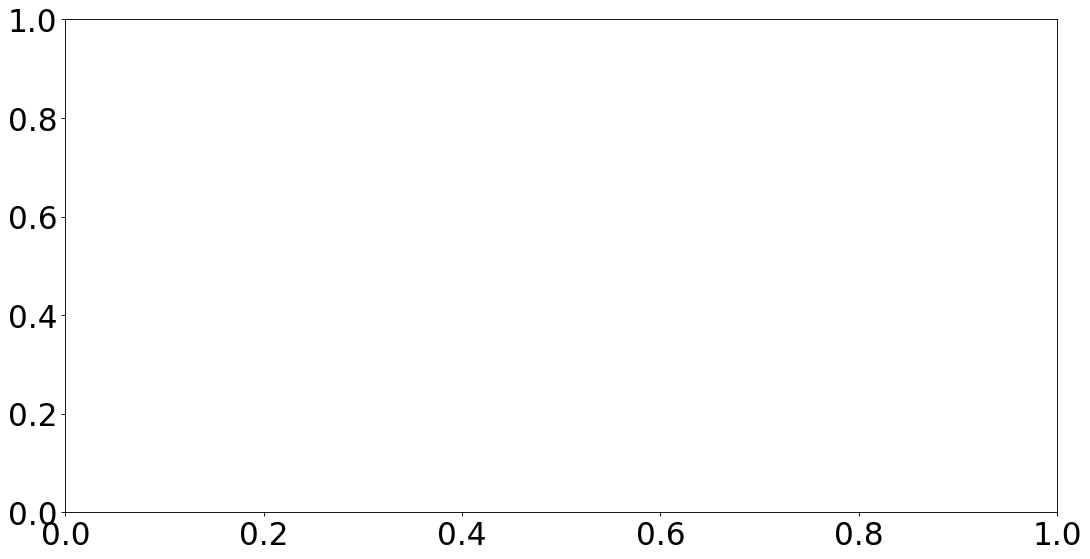

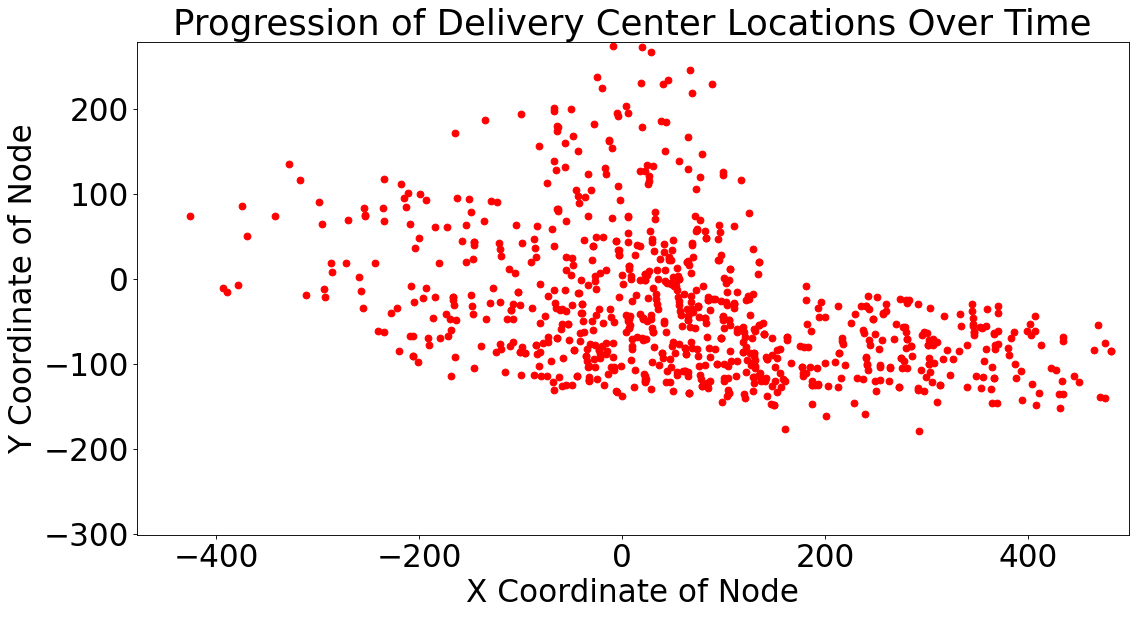

In [42]:
if do_ablation:
    for exp_k in k_to_try:
        for exp_lam in lam_to_try:
            print("Trying " + str(exp_k) + "for K value, " + str(exp_lam) + " for lambda value")
            sa_solver = SASolveFacilityProblem(
                prepared_dataset,
                total_deliveries, 
                facility_capacity, 
                facility_cost, 
                facility_increase_prob, 
                facility_decrease_prob, 
                len(prepared_dataset) // num_neighbours_nodes_div,
                num_iterations,
                exp_k,
                exp_lam
            )
            sa_solver.initialize()
            sa_solver.solve()
            sa_solver.visualize_solution()
            sa_solver.write_costs_overtime_to_csv()
            sa_solver.write_facility_placements_to_csv()
            if sa_solver.solution_cost < best_solution_cost:
                best_k = exp_k
                best_lam = exp_lam
                best_solution_cost = sa_solver.solution_cost
    print("Best K value found: " + str(best_k))
    print("Best lambda value found: " + str(best_lam))
else:
    sa_solver = SASolveFacilityProblem(
        prepared_dataset,
        total_deliveries, 
        facility_capacity, 
        facility_cost, 
        facility_increase_prob, 
        facility_decrease_prob, 
        len(prepared_dataset) // num_neighbours_nodes_div,
        num_iterations,
        k_to_try[0],
        lam_to_try[5]
    )
    sa_solver.initialize()
    sa_solver.solve()
    sa_solver.visualize_solution()
    sa_solver.write_costs_overtime_to_csv()
    sa_solver.write_facility_placements_to_csv()

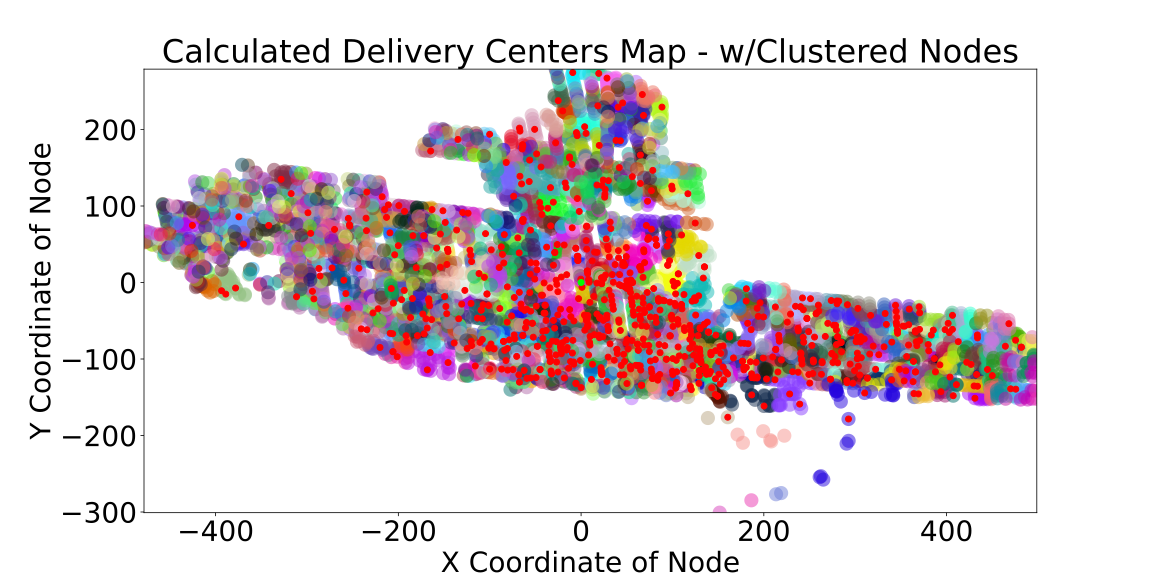

In [43]:
display(SVG(filename=sa_solver.get_solution_image_name()))

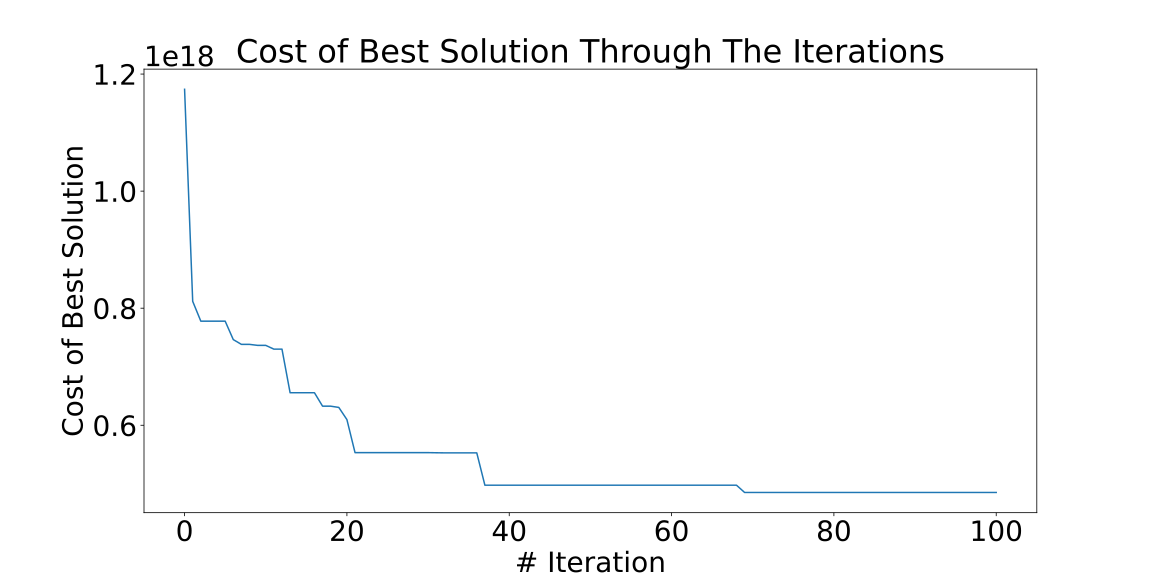

In [44]:
display(SVG(filename=sa_solver.get_progression_graph_name()))

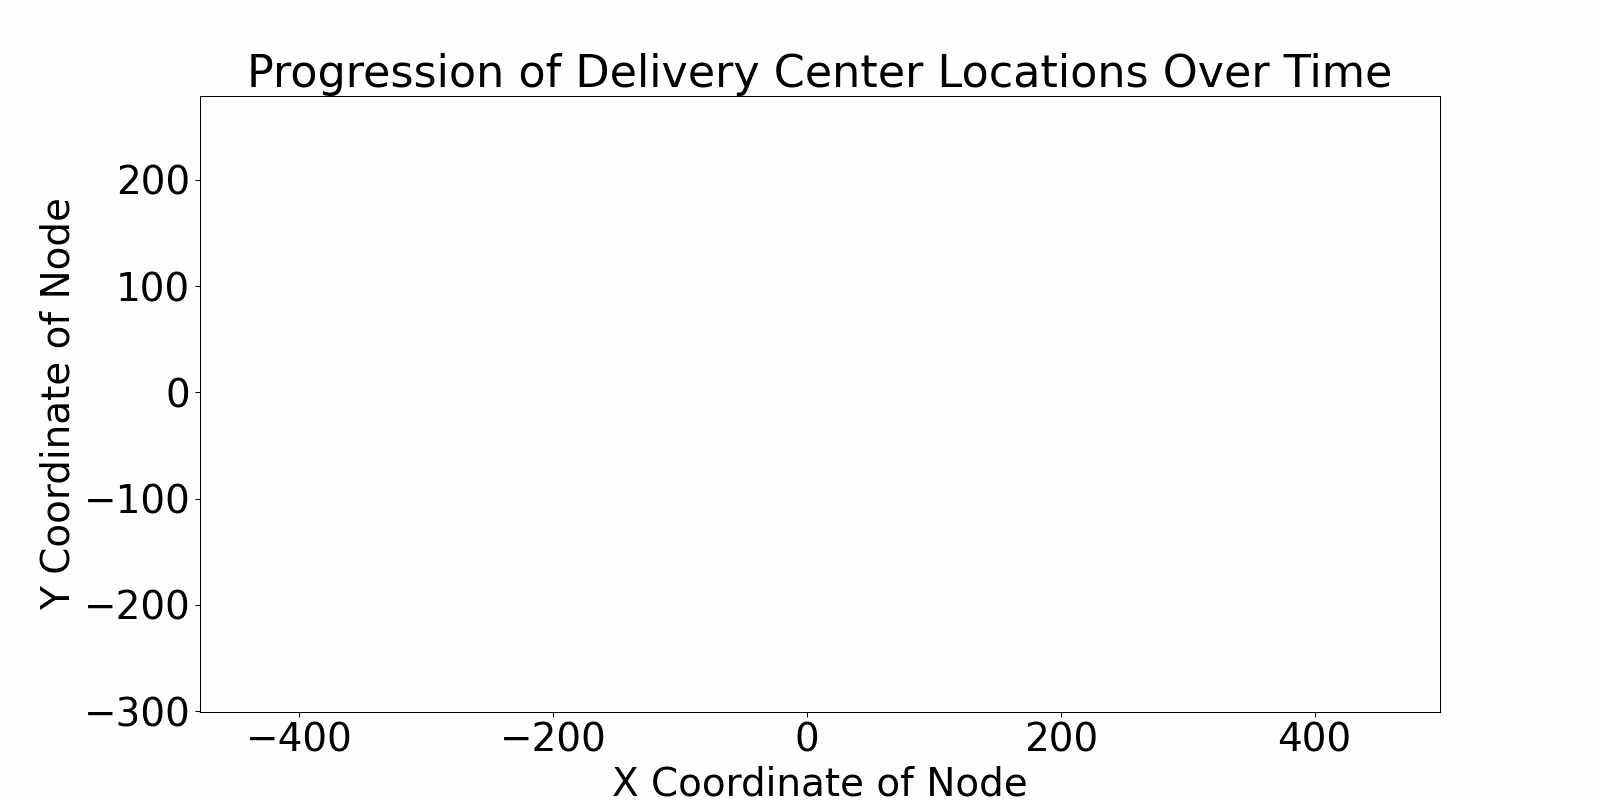

In [45]:
display(Image(data=open(sa_solver.get_animation_name(),'rb').read(), format='gif'))

# Genetic Algorithm Location Problem Solver

In [46]:
class GASolveFacilityProblem:
    def __init__(
            self, 
            nodes_info,
            total_deliveries, 
            facility_capacity, 
            facility_cost, 
            population_size, 
            num_iterations, 
            num_parents, 
            mutation_prob, 
            facility_increase_prob, 
            facility_decrease_prob, 
            len_nodes_mutation,
            crossover_prob
    ):

        self.nodes_info = nodes_info
        self.total_deliveries = total_deliveries
        self.min_facilities = math.ceil(self.total_deliveries / float(facility_capacity)) # there have to be at least CAP / NUM_DELIVERIES facilities to serve demand
        self.facility_cost = facility_cost
        self.facility_capacity = facility_capacity
        self.cost_matrix = None
        self.ordered_matrix = None
        self.distance_from_downtown_matrix = None
        self.nodes_len_mutation = len_nodes_mutation # the number of closest nodes to be considered for the mutation

        self.estimated_dtwn_x = -3.7178296565262885e-14
        self.estimated_dtwn_y = -2.6310964646970894e-13
        self.max_distance_to_dtwn = 0
        self.min_distance_to_dtwn = 0
        self.min_bid_rent_multiplier = 0.3

        self.overdemand_penalty = 100

        self.pop_size = population_size
        self.iterations = num_iterations
        self.num_parents = num_parents
        self.mutation_prob = mutation_prob
        self.facility_increase_prob = facility_increase_prob
        self.facility_decrease_prob = facility_decrease_prob
        self.crossover_prob = crossover_prob
        self.min_x = 0
        self.max_x = 0
        self.min_y = 0
        self.max_y = 0
        self.x_resolution = 0 # = (self.x_max - self.x_min) / len(self.nodes_info)
        self.y_resolution = 0 # = (self.y_max - self.y_min) / len(self.nodes_info)

        self.population = []
        self.costs = []
        self.states = []
        self.states_full = []
        self.solution = None
        self.solution_cost = None

        self.infinity = float("inf")

        random.seed(100) # to keep consistency through different runs

    def calculate_closest_nodes(self, solution):
        facilities_closest_nodes = [[] for i in range(len(solution))]
        facilities_available_space = [self.facility_capacity for i in range(len(solution))]
        visited_nodes_set = set()
        for i, facility in enumerate(solution):
            closest_node_indexes = self.ordered_matrix[facility[2]]
            for node_id in closest_node_indexes:
                node_cost = self.nodes_info[node_id][2]
                if node_id not in visited_nodes_set and facilities_available_space[i] - node_cost >= 0:
                    facilities_closest_nodes[i].append([node_id, self.cost_matrix[facility[2]][node_id]])
                    facilities_available_space[i] -= node_cost
                    visited_nodes_set.add(node_id)
                elif node_id not in visited_nodes_set and facilities_available_space[i] - node_cost < 0:
                    break
        all_nodes_set = set(range(0, len(self.nodes_info)))
        not_visited_nodes_set = list(all_nodes_set.difference(visited_nodes_set))

        for node_id in not_visited_nodes_set:

            node_cost = self.nodes_info[node_id][2]

            most_available_facility = 0
            available_space_at_facility = facilities_available_space[most_available_facility]
            for i, facility in enumerate(solution):
                if available_space_at_facility < facilities_available_space[i]:
                    most_available_facility = i
                    available_space_at_facility = facilities_available_space[i]
            facilities_closest_nodes[most_available_facility].append([node_id, self.cost_matrix[most_available_facility][node_id]])
            facilities_available_space[most_available_facility] -= node_cost

        return facilities_closest_nodes

    def calculate_facility_cost(self, facility_closest_nodes):
        total_cost = 0
        total_demand = 0
        for node in facility_closest_nodes:
            total_cost += node[1] * self.nodes_info[node[0]][2]  # add the distance from node to facility and back, which is already squared, times the demand for that node
            total_demand += self.nodes_info[node[0]][2]
        return total_cost if total_demand <= self.facility_capacity else total_cost * self.overdemand_penalty
        #return total_cost / len(facility_closest_nodes) + self.facility_cost

    def gen_random_solution(self):
        gen_facilities = []
        copy_nodes_info = deepcopy(self.nodes_info)
        for i in range(0, self.min_facilities):
            random_node_id = random.randint(0, len(copy_nodes_info) - 1)
            selected_node = copy_nodes_info.pop(random_node_id)
            selected_node.append(random_node_id)
            gen_facilities.append(selected_node)
        return gen_facilities

    # Order one crossover implementation, with different sized list implementation
    def crossover(self, parent1, parent2):
        p1_length = len(parent1)
        p2_length = len(parent2)
        child = list()
        if p1_length > p2_length:
            start_segment = random.randint(0, p2_length // 2)
            end_segment = random.randint(p2_length // 2 + 1, p2_length - 1) + 1
            child.extend(parent2[start_segment : end_segment])
            child.extend(parent1[:start_segment])
            child.extend(parent1[end_segment:])
        else:
            start_segment = random.randint(0, p1_length // 2)
            end_segment = random.randint(p1_length // 2 + 1, p1_length - 1) + 1
            child.extend(parent1[start_segment : end_segment])
            child.extend(parent2[:start_segment])
            child.extend(parent2[end_segment:])
        return child

    # custom mutation function for facility location problem
    # first, we mutate facility locations to a nearby node
    # then we randomly decide if we increment the number of facilities, decrement it or keep it the same
    def mutate(self, pop_element):
        mutated_population_element = []
        for facility in pop_element:
            sorted_closest_nodes = self.ordered_matrix[facility[2]]
            random_index = random.randint(0, self.nodes_len_mutation)
            new_node_index = sorted_closest_nodes[random_index]
            new_x = self.nodes_info[new_node_index][0]
            new_y = self.nodes_info[new_node_index][1]

            mutated_population_element.append([new_x, new_y, new_node_index])
        
        # if we randomly decide to eliminate a facility from the population element
        if len(pop_element) > self.min_facilities and random.random() > self.facility_decrease_prob:
            # remove the last element from the population element (last facility)
            mutated_population_element.pop(len(mutated_population_element) - 1)
        
        # if we randomly decide to add a facility to the population element
        if random.random() > self.facility_increase_prob:
            random_new_index_node = random.randint(0, len(self.nodes_info) - 1)
            new_facility_node = self.nodes_info[random_new_index_node]
            mutated_population_element.append([new_facility_node[0], new_facility_node[1], random_new_index_node])

        return mutated_population_element

    def facility_placement_cost(self, facility_id):
        distance_to_downtown = self.distance_from_downtown_matrix[facility_id]
        bid_rent_multiplier = 1 - self.min_bid_rent_multiplier * (distance_to_downtown - self.min_distance_to_dtwn) / (self.max_distance_to_dtwn - self.min_distance_to_dtwn)
        return bid_rent_multiplier

    def fitness_one(self, solution):
        total_cost = 0
        facilities_closest_nodes = self.calculate_closest_nodes(solution)
        for i, closest_nodes in enumerate(facilities_closest_nodes):
            cost = self.calculate_facility_cost(closest_nodes)
            bid_rent_multiplier = self.facility_placement_cost(solution[i][2])
            total_cost += cost * bid_rent_multiplier
        total_cost = total_cost * (len(solution) ** 2) # heavily penalize the number of facilities to minimize them
        return total_cost

    def fitness_all(self, population):
        total_costs = Parallel(n_jobs=8)(delayed(self.fitness_one)(population[i]) for i in range(len(population)))
        return total_costs

    def init_population(self):
        first_node = True
        for node in self.nodes_info:
            if first_node:
                self.max_x = node[0]
                self.min_x = node[0]
                self.max_y = node[1]
                self.min_y = node[1]
                first_node = False
            else:
                if node[0] > self.max_x:
                    self.max_x = node[0]
                if node[0] < self.min_x:
                    self.min_x = node[0]
                if node[1] > self.max_y:
                    self.max_y = node[1]
                if node[1] < self.min_y:
                    self.min_y = node[1]
        
        self.x_resolution = (self.max_x - self.min_x) / len(self.nodes_info)
        self.y_resolution = (self.max_y - self.min_y) / len(self.nodes_info)

        self.cost_matrix = np.zeros((len(self.nodes_info), len(self.nodes_info)))
        print("Initializing cost matrix...")
        for i, node_i in enumerate(self.nodes_info):
            for j, node_j in enumerate(self.nodes_info):
                x_dist = node_i[0] - node_j[0]
                y_dist = node_i[1] - node_j[1]
                self.cost_matrix[i, j] = x_dist * x_dist + y_dist * y_dist # distance without sqrt to increase performance (dirty distance)
        print("Initialized cost matrix")
        print("Initializing the ordered index closest nodes matrix...")
        temp_ordered_matrix = []
        for i in range(0, len(self.nodes_info)):
            node_i_ordered_indexes = np.argsort(self.cost_matrix[i])
            temp_ordered_matrix.append(node_i_ordered_indexes.tolist())
        self.ordered_matrix = np.array(temp_ordered_matrix)
        print("Initialized the ordered index closest nodes matrix")   

        print("Initializing the distance to downtown matrix...")
        self.distance_from_downtown_matrix = np.zeros(len(self.nodes_info))
        for i, node_i in enumerate(self.nodes_info):
            x_dist = self.estimated_dtwn_x - node_i[0]
            y_dist = self.estimated_dtwn_y - node_i[1]
            self.distance_from_downtown_matrix[i] = x_dist * x_dist + y_dist * y_dist
        self.max_distance_to_dtwn = np.max(self.distance_from_downtown_matrix)
        self.min_distance_to_dtwn = np.min(self.distance_from_downtown_matrix)
        # print(self.max_distance_to_dtwn)
        # print(self.min_distance_to_dtwn)
        # exit()
        print("Initialized the distance to downtown matrix")

        for _ in range(0, self.pop_size):
            self.population.append(self.gen_random_solution())
        self.costs = self.fitness_all(self.population)
        print("Initialized initial population.")

    def solve(self):
        # Check that initial population exists:
        if self.population:
            # Show some information
            print("Initial Population costs:")
            print(self.costs)
        else:
            raise Exception("Population not initialized.")
        
        start_time = time.time()
        for iter in range(self.iterations):
            print("Iteration ", str(iter))
            self.costs = self.fitness_all(self.population)
            self.states.append(min(self.costs))
            self.states_full.append(min(self.population, key=lambda x: self.costs[self.population.index(x)]))

            parents = nsmallest(self.num_parents,self.population, key=lambda x: self.costs[self.population.index(x)])

            offspring = []
            new_population = []
            for p1, p2 in zip(parents[:len(parents)//2],parents[len(parents)//2:]):
                # Crossover probability
                if random.random() < self.crossover_prob:
                    offspring.append(self.crossover(p1,p2))
                    offspring.append(self.crossover(p2,p1))
                else:
                    offspring.append(p1)
                    offspring.append(p2)
            for child in offspring:
                if random.random() < self.mutation_prob:
                    new_population.append(self.mutate(child))
                else:
                    new_population.append(child)
            new_population.extend(parents)
            self.population = new_population
        end_time = time.time()
        
        # Show best solution
        self.costs = self.fitness_all(self.population)
        self.solution = min(self.population, key=lambda x: self.costs[self.population.index(x)])
        self.states.append(min(self.costs))
        self.states_full.append(self.solution)
        print("Minimum: ", min(self.population, key=lambda x: self.costs[self.population.index(x)]))
        self.solution_cost = self.costs[self.population.index(self.solution)]
        print("Best Solution:", self.solution)
        print("Best Solution Cost:", self.solution_cost)
        print("Total time to complete: " + str(end_time - start_time) + " seconds")

    def visualize_solution(self):
        large = 32; med = 28; small = 24
        params = {'axes.titlesize': large,
                    'legend.fontsize': large,
                    'figure.figsize': (16, 10),
                    'axes.labelsize': med,
                    'axes.titlesize': med,
                    'xtick.labelsize': med,
                    'ytick.labelsize': med,
                    'figure.titlesize': large}
        plt.rcParams.update(params)

        plt.figure(figsize=(16,8), dpi= 80)
        plt.ylabel("Y Coordinate of Node", fontsize=med)  
        plt.xlabel("X Coordinate of Node", fontsize=med) 
        plt.title("Calculated Delivery Centers Map - w/Clustered Nodes", fontsize=large)
        plt.xlim((self.min_x, self.max_x))
        plt.ylim((self.min_y, self.max_y))

        nodes_per_facility = self.calculate_closest_nodes(self.solution)
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(nodes_per_facility))]
        total_deliveries_served = 0
        for i, facility_close_nodes in enumerate(nodes_per_facility):
            x_coordinates = []
            y_coordinates = []
            total_deliveries_assigned = 0
            for node in facility_close_nodes:
                x_coordinates.append(self.nodes_info[node[0]][0])
                y_coordinates.append(self.nodes_info[node[0]][1])
                total_deliveries_assigned += self.nodes_info[node[0]][2]
                total_deliveries_served += self.nodes_info[node[0]][2]
            print("Facility " + str(i) + " has " + str(total_deliveries_assigned) + " deliveries assigned to it.")
            plt.scatter(x_coordinates, y_coordinates, color=color[i], alpha=0.5, edgecolors='none', s=200)
        print("The total number of deliveries served is " + str(total_deliveries_served))
        x_coordinates = []
        y_coordinates = []
        for facility in self.solution:
            x_coordinates.append(facility[0])
            y_coordinates.append(facility[1])
        plt.scatter(x_coordinates, y_coordinates, color="#FF0000")
        plt.savefig("mut" + str(self.mutation_prob) + "_covr" + str(self.crossover_prob) + "ga_solution.svg", format="svg")

        plt.cla()
        large = 32; med = 28; small = 24
        params = {'axes.titlesize': large,
                    'legend.fontsize': large,
                    'figure.figsize': (16, 10),
                    'axes.labelsize': med,
                    'axes.titlesize': med,
                    'xtick.labelsize': med,
                    'ytick.labelsize': med,
                    'figure.titlesize': large}
        plt.rcParams.update(params)

        plt.figure(figsize=(16,8), dpi= 80)
        plt.ylabel("Cost of Best Solution", fontsize=med)  
        plt.xlabel("# Iteration", fontsize=med) 
        plt.title("Cost of Best Solution Through The Iterations", fontsize=large)
        plt.plot(self.states)
        plt.savefig("mut" + str(self.mutation_prob) + "_covr" + str(self.crossover_prob) + "ga_solution_progression.svg", format="svg")

        plt.cla()

        writer = PillowWriter(fps=5)
        large = 32; med = 28; small = 24
        params = {'axes.titlesize': large,
                    'legend.fontsize': large,
                    'figure.figsize': (16, 10),
                    'axes.labelsize': med,
                    'axes.titlesize': med,
                    'xtick.labelsize': med,
                    'ytick.labelsize': med,
                    'figure.titlesize': large}
        plt.rcParams.update(params)

        fig2 = plt.figure(figsize=(16,8), dpi= 80)
        plt.ylabel("Y Coordinate of Node", fontsize=med)  
        plt.xlabel("X Coordinate of Node", fontsize=med) 
        plt.title("Progression of Delivery Center Locations Over Time", fontsize=large)
        plt.xlim((self.min_x, self.max_x))
        plt.ylim((self.min_y, self.max_y))
        animation_points = []
        with writer.saving(fig2, "mut" + str(self.mutation_prob) + "_covr" + str(self.crossover_prob) + "ga_facility_locations_progression.gif", 100):
            for i in range(0, len(self.states_full)):
                x_coordinates = []
                y_coordinates = []
                for facility in self.states_full[i]:
                    x_coordinates.append(facility[0])
                    y_coordinates.append(facility[1])
                writer.grab_frame()
                animation_points.append(plt.scatter(x_coordinates, y_coordinates, color="#FF0000"))
                if len(animation_points) == 2:
                    animation_points[0].remove()
                    animation_points.pop(0)

    def write_costs_overtime_to_csv(self):
        print("Saving solution progression to .csv file...")
        save_path = Path("mut" + str(self.mutation_prob) + "_covr" + str(self.crossover_prob) + "_ga_progression.csv")
        with open(save_path, mode='w', encoding='utf-8') as solutionwriter:
            csvsolutionwriter = csv.writer(solutionwriter, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csvsolutionwriter.writerow(["cost"])
            for state in self.states:
                csvsolutionwriter.writerow([state])

    def write_facility_placements_to_csv(self):
        print("Saving final facility placements to .csv file...")
        save_path = Path("mut" + str(self.mutation_prob) + "_covr" + str(self.crossover_prob) + "_ga_locations.csv")
        with open(save_path, mode='w', encoding='utf-8') as solutionwriter:
            csvsolutionwriter = csv.writer(solutionwriter, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csvsolutionwriter.writerow(["node_id", "x", "y"])
            for facility in self.solution:
                csvsolutionwriter.writerow([facility[2], facility[0], facility[1]])
    
    def get_csv_file_name(self):
        return "./mut" + str(self.mutation_prob) + "_covr" + str(self.crossover_prob) + "_ga_locations.csv"

    def get_solution_image_name(self):
        return "./mut" + str(self.mutation_prob) + "_covr" + str(self.crossover_prob) + "ga_solution.svg"

    def get_progression_graph_name(self):
        return "./mut" + str(self.mutation_prob) + "_covr" + str(self.crossover_prob) + "ga_solution_progression.svg"
    
    def get_animation_name(self):
        return "./mut" + str(self.mutation_prob) + "_covr" + str(self.crossover_prob) + "ga_facility_locations_progression.gif"

In [47]:
# loads the synthetic dataset from a .csv file
# the synthetic dataset must have the following columns:
# Node ID, Node OSMID, X, Y, Node Weight, Number Deliveries
def load_dataset(string_path):
    dataset_path = Path(string_path)
    nodes_info = []
    print("Opening dataset file and loading dataset...")
    with open(dataset_path, mode='r', encoding='utf-8') as datasetreader:
        csvdatasetreader = csv.reader(datasetreader, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        line_number = 0
        for row in csvdatasetreader:
            if line_number == 0:
                print("Reading synthetic dataset file")
                line_number += 1
            else:
                node_id = int(row[0])
                node_osmid = int(float(row[1]))
                node_x = float(row[2])
                node_y = float(row[3])
                node_weight = float(row[4])
                node_deliveries = int(row[5])
                nodes_info.append([node_id, node_osmid, node_x, node_y, node_weight, node_deliveries])
    print("Dataset loaded! Found " + str(len(nodes_info)) + " nodes.")
    return nodes_info

In [48]:
# unwraps or expands the deliveries in each node, converting them to nodes with the same coordinates
# for ease of use in the algorithms
def prepare_dataset(nodes_info):
    prepared_dataset = []
    print("Preparing the dataset for use in the algorithms...")
    total_deliveries = 0
    for node in nodes_info:
        # only save node X,Y coordinates, as after expanding the deliveries, this is all that matters
        prepared_dataset.append([node[2], node[3], node[5]])
        total_deliveries += node[5]
    print("Dataset preparation complete! Expanded " + str(len(prepared_dataset)) + " deliveries.")
    return total_deliveries, prepared_dataset

In [49]:
facility_capacity = 1200
facility_cost = 5000
population_size = 8
num_iterations = 100
num_parents = 4
mutation_prob = 0.9
crossover_prob = 0.9
facility_increase_prob = 0.5
facility_decrease_prob = 0.7
len_mutation_nodes_div = 20

Opening dataset file and loading dataset...
Reading synthetic dataset file
Dataset loaded! Found 5797 nodes.
Preparing the dataset for use in the algorithms...
Dataset preparation complete! Expanded 5797 deliveries.
Initializing cost matrix...
Initialized cost matrix
Initializing the ordered index closest nodes matrix...
Initialized the ordered index closest nodes matrix
Initializing the distance to downtown matrix...
Initialized the distance to downtown matrix
Initialized initial population.
Initial Population costs:
[1.173990942594572e+18, 1.1867651126262943e+18, 1.13211049627473e+18, 1.1426032937385578e+18, 1.098620957690499e+18, 1.115135403311419e+18, 1.1105250012287912e+18, 1.1787055094354253e+18]
Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19
Iteration  20
Iter

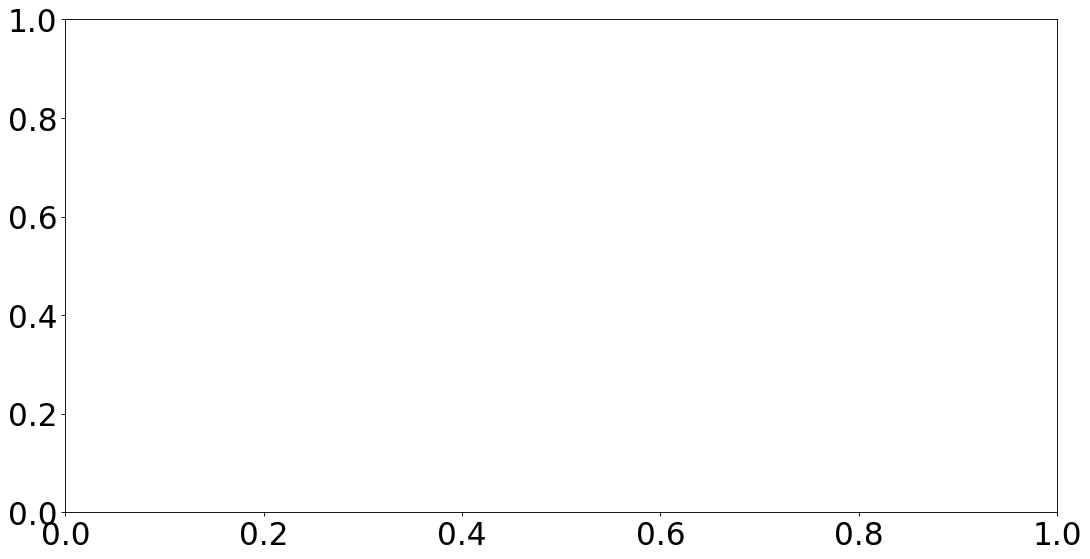

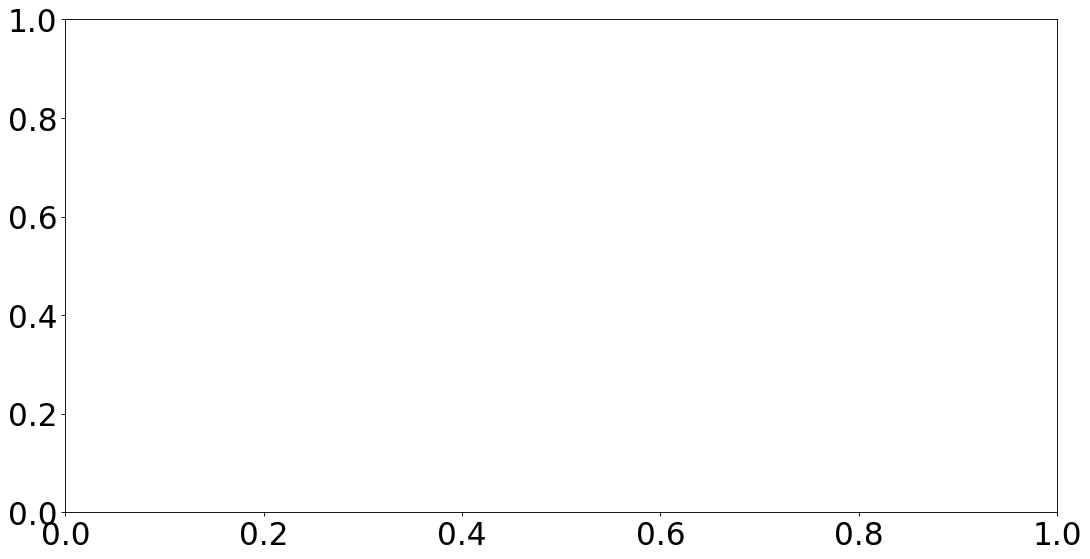

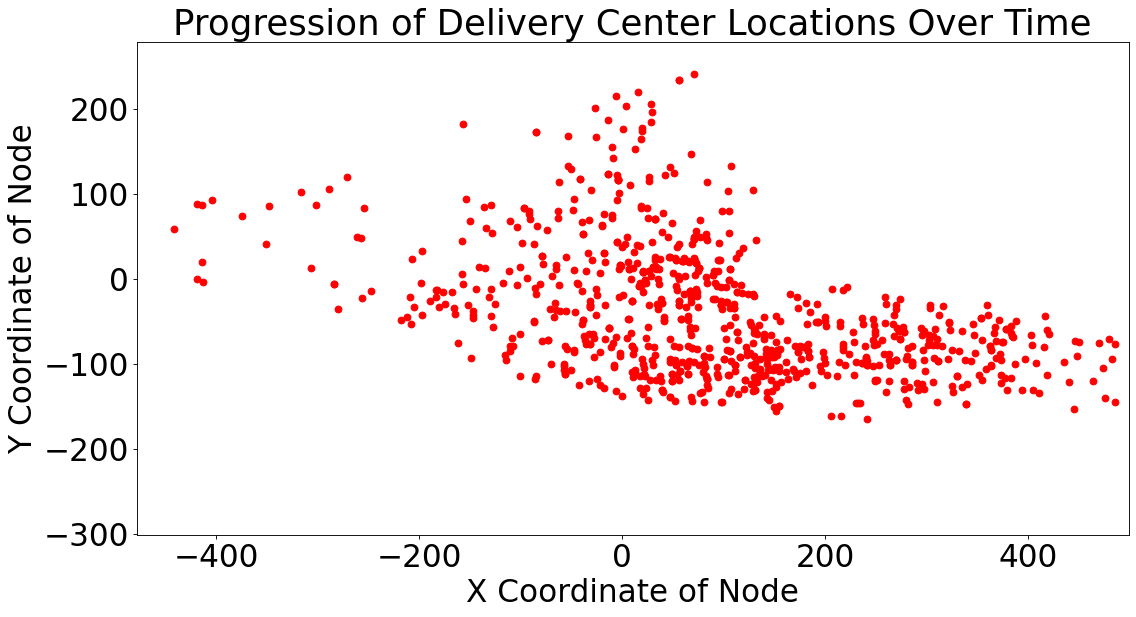

In [50]:
dataset = load_dataset("./DatasetGen/synthetic_dataset.csv")
total_deliveries, prepared_dataset = prepare_dataset(dataset)
ga_solver = GASolveFacilityProblem(
    prepared_dataset, 
    total_deliveries,
    facility_capacity, 
    facility_cost, 
    population_size, 
    num_iterations, 
    num_parents, 
    mutation_prob, 
    facility_increase_prob, 
    facility_decrease_prob, 
    len(prepared_dataset) // len_mutation_nodes_div,
    crossover_prob
)
ga_solver.init_population()
ga_solver.solve()
ga_solver.visualize_solution()
ga_solver.write_costs_overtime_to_csv()
ga_solver.write_facility_placements_to_csv()

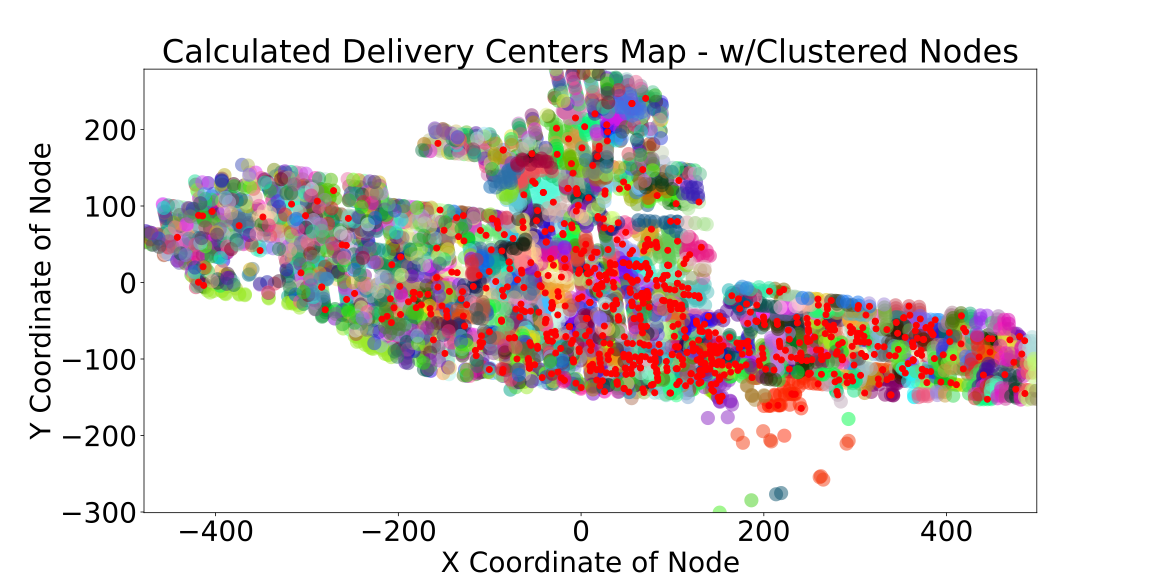

In [51]:
display(SVG(filename=ga_solver.get_solution_image_name()))

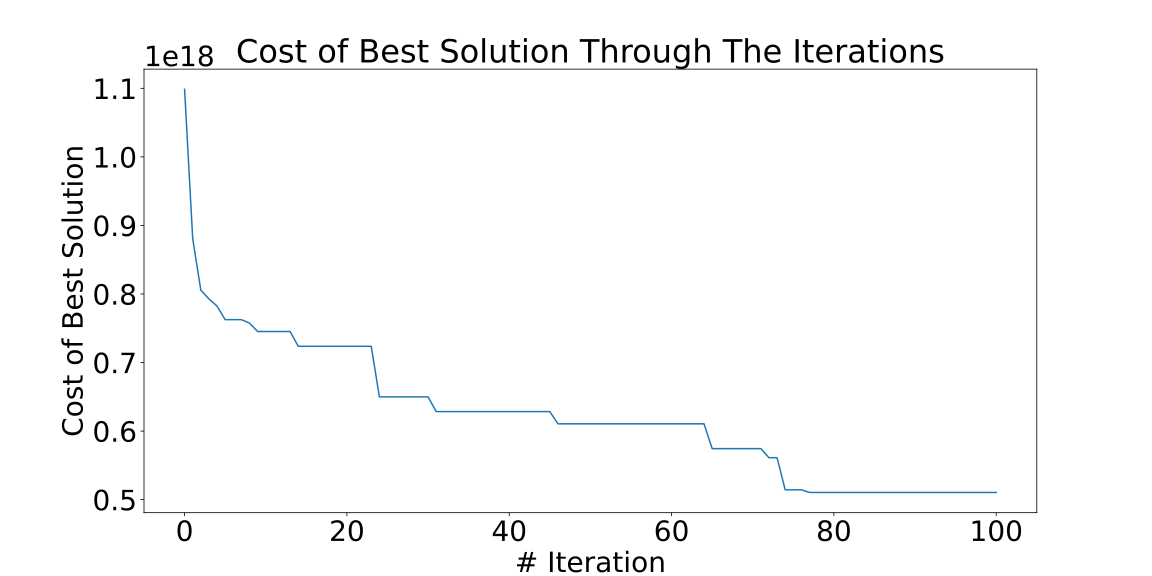

In [52]:
display(SVG(filename=ga_solver.get_progression_graph_name()))

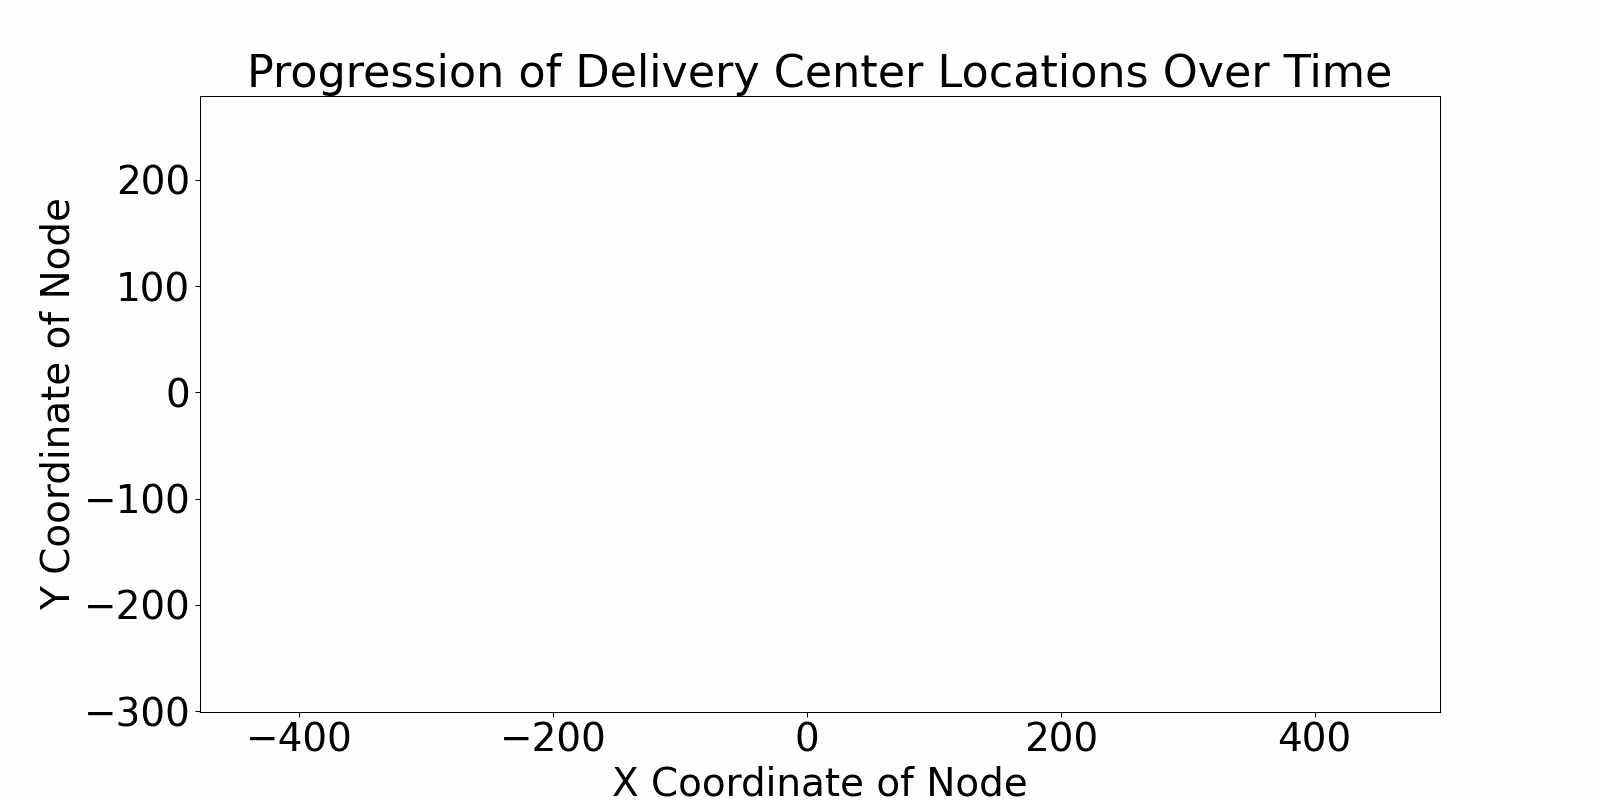

In [53]:
display(Image(data=open(ga_solver.get_animation_name(),'rb').read(), format='gif'))

# Assignment Problem Naive Solver

In [66]:
df = pd.read_csv("./DatasetGen/synthetic_dataset.csv")
df.rename(columns = {'Number Deliveries':'demand'}, inplace=True)
df.sort_values(by=['demand'], ascending=False, inplace=True)
print(df.columns.tolist())
demands = df["demand"]
df = df[["X", "Y"]]
data = df.to_numpy()

sa_location = sa_solver.get_csv_file_name()
ga_loaction = ga_solver.get_csv_file_name()
kmeans_location = "./Kmeans_cluster.csv"
# SELECT ONE
facilities = pd.read_csv(sa_location)
#facilities = pd.read_csv(ga_loaction)
#facilities = pd.read_csv(kmeans_location)
facilities = facilities[["x", "y"]]
depots = facilities.to_numpy()

['Node ID', 'Node OSMID', 'X', 'Y', 'Node Weight', 'demand']


In [67]:
min_bid_rent_multiplier = 0.7

max_distance_to_dtwn = np.max(np.linalg.norm(data, axis=1))
min_distance_to_dtwn = np.min(np.linalg.norm(data, axis=1))

In [68]:
np.max(np.linalg.norm(depots, axis=1))

495.76667492366124

In [69]:
capacity_perfacility = 1200
capacities = capacity_perfacility * np.ones(depots.shape[0])
def get_multiplier(min_bid_rent_multiplier, min_distance_to_dtwn, max_distance_to_dtwn, depot_norm):
    return (1 - min_bid_rent_multiplier *\
                 (depot_norm - min_distance_to_dtwn)\
            / (max_distance_to_dtwn - min_distance_to_dtwn)) 

In [70]:
result = np.zeros((data.shape[0], depots.shape[0]))
cost = 0
for i in range(data.shape[0]):
    node = data[i]
    distances = np.linalg.norm(depots - node, axis=1)
    distances = get_multiplier(min_bid_rent_multiplier, min_distance_to_dtwn,\
                               max_distance_to_dtwn, np.linalg.norm(depots, axis=1))*distances
    min_distance_depot = np.argsort(distances)
    for j in min_distance_depot:
        if capacities[j] == 0:
            continue
        if capacities[j] >= demands[i]:
            cost += distances[j] * (demands[i]/1200)
            result[i][j] += demands[i]
            capacities[j] -= demands[i]
            demands[i] = 0
            break
        else:
            cost += distances[j] * (demands[i]/1200)
            result[i][j] += capacities[j]
            demands[i] -= capacities[j]
            capacities[j] = 0
        if demands[i] <= 0:
            break

In [71]:
print(f"total cost: {cost}")
print(f"left over capacities: {np.sum(capacities[np.nonzero(capacities)[0]])}")
print(f"remaining demand: {np.sum(demands)}")

total cost: 83382.97368784864
left over capacities: 9200.0
remaining demand: 0


# Assignment Problem Simulated Annealing Solver

In [72]:
df = pd.read_csv("./DatasetGen/synthetic_dataset.csv")
df.rename(columns = {'Number Deliveries':'demand'}, inplace=True)
df.sort_values(by=['demand'], ascending=False, inplace=True)
print(df.columns.tolist())
demands = df["demand"].to_numpy()
df = df[["X", "Y"]]
data = df.to_numpy()

facilities = pd.read_csv(kmeans_location)
facilities = facilities[["x", "y"]]
depots = facilities.to_numpy()

['Node ID', 'Node OSMID', 'X', 'Y', 'Node Weight', 'demand']


In [73]:
def exp_schedule(k=20, lam=0.005, limit=100):
    function = lambda t: (k * np.exp(-lam*t) if t <limit else 0)
    return function

def random_search(coords, volumes, locations): 
    cap = capacity_perfacility * np.ones(locations.shape[0])
    indices = np.arange(coords.shape[0])
    np.random.shuffle(indices)
    da, ds = np.copy(coords)[indices], np.copy(volumes)[indices]
    r = np.zeros((da.shape[0], locations.shape[0]))
    c = 0
    for i in range(da.shape[0]):
        node = da[i]
        distances = np.linalg.norm(locations - node, axis=1)
        distances = get_multiplier(min_bid_rent_multiplier, min_distance_to_dtwn,\
                               max_distance_to_dtwn, np.linalg.norm(depots, axis=1)) * distances
        min_distance_depot = np.argsort(distances)
        for j in min_distance_depot:
            if cap[j] == 0:
                continue
            if cap[j] >= ds[i]:
                c += distances[j] * (ds[i]/1200)
                r[i][j] += ds[i]
                cap[j] -= ds[i]
                ds[i] = 0
                break
            else:
                c += distances[j] * (ds[i]/1200)
                r[i][j] += cap[j]
                ds[i] -= cap[j]
                cap[j] = 0
            if ds[i] <= 0:
                break
    return r, c

In [74]:
def simulated_annealing(initial_solution, num_iter, schedule_function, neighbour_function, coords, volume, locations):
    current, current_cost = initial_solution
    assert(current_cost != 0)
    states = [current_cost]
    for t in range(num_iter):
        T = schedule_function(t)
        next_choice, next_cost = neighbour_function(coords, volume, locations)
        current_cost = states[-1]
        delta_e = next_cost - current_cost
        if delta_e < 0 or probability(np.exp(-1 * delta_e / T)):
            current = next_choice
            states.append(next_cost)
        else: 
            states.append(current_cost)
    return current, states[-1], states

In [75]:
distribution_solution = np.zeros((data.shape[0], depots.shape[0]))
num_iterations = 100
exp_schedule_k = 100
exp_schedule_lam = 0.05
total_cost = 0

schedule = exp_schedule(exp_schedule_k, exp_schedule_lam, num_iterations)
initial_solution = (result, cost)
distribution_solution, total_cost, cost_curve = simulated_annealing(
    initial_solution,
    num_iterations,
    schedule,
    random_search,
    np.copy(data),
    np.copy(demands),
    np.copy(depots)
    )

In [76]:
left_over_capacity = np.sum(capacity_perfacility * np.ones(depots.shape[0]) - np.sum(distribution_solution, axis=0))

print(f"total cost: {total_cost}")
print(f"left over capacities: {np.sum(left_over_capacity)}")
print(f"remaining demand: {np.sum(demands - np.sum(distribution_solution, axis=1))}")

total cost: 35028.90127158174
left over capacities: 800.0
remaining demand: 0.0


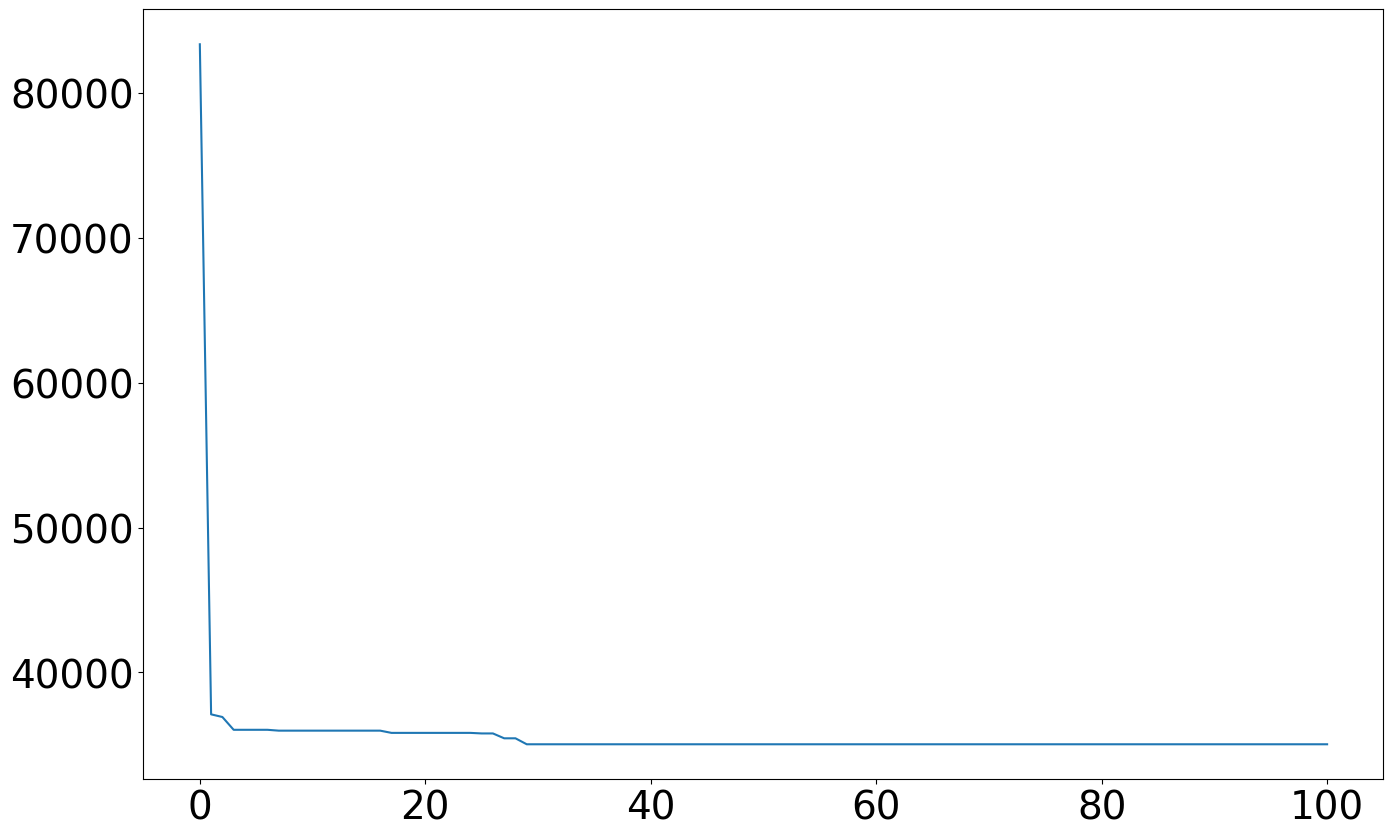

In [77]:
plt.plot(cost_curve)